In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.4 MB/s 


In [7]:
#import required modules
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse
import tldextract
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# set random seed 
'''
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
'''

"\nos.environ['PYTHONHASHSEED'] = '0'\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'\nnp.random.seed(0)\nrandom.seed(0)\ntf.random.set_seed(0)\n"

In [18]:
# other setup
'''
%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 500)
deprecation._PRINT_DEPRECATION_WARNINGS = False
'''

"\n%config InlineBackend.figure_format = 'retina'\npd.set_option('max_colwidth', 500)\ndeprecation._PRINT_DEPRECATION_WARNINGS = False\n"

In [19]:
# Reading the files into two dataframes.
malicious = pd.read_csv('/content/drive/MyDrive/malicious_dataset.csv')
attack_label = pd.read_csv('/content/drive/MyDrive/attack_labels.csv')
normal_data = pd.read_csv('/content/drive/MyDrive/normal_dataset.csv')


# Merging the two dataframes, using _ID column as key

merged_data = pd.merge(malicious, attack_label, on = 'ip.src')
merged_data = merged_data.append(normal_data)

print(merged_data)

merged_data.set_index('ip.src', inplace = True)

# Writing it to a new CSV file named group project
merged_data.to_csv('/content/drive/MyDrive/groupproject.csv')

        frame_info.encap_type                      frame_info.time  \
0                           1  Dec 31, 1969 21:03:41.953641000 -03   
1                           1  Dec 31, 1969 21:03:41.953762000 -03   
2                           1  Dec 31, 1969 21:03:41.953792000 -03   
3                           1  Dec 31, 1969 21:03:41.953817000 -03   
4                           1  Dec 31, 1969 21:03:41.953854000 -03   
...                       ...                                  ...   
103089                      1  Nov 21, 2019 02:01:18.308255000 -03   
103090                      1  Nov 21, 2019 02:01:18.308601000 -03   
103091                      1  Nov 21, 2019 02:01:18.309464000 -03   
103092                      1  Nov 21, 2019 02:01:18.311302000 -03   
103093                      1  Nov 21, 2019 02:01:18.311362000 -03   

        frame_info.time_epoch  frame_info.number  frame_info.len  \
0                2.219536e+02                 20              58   
1                2.2195

In [20]:
# load dataset. storing it in variable named ds
import pandas as pd
ds = pd.read_csv('/content/drive/MyDrive/groupproject.csv')
# shuffle data
ds = ds.sample(frac=1, random_state=0)
print(f'Data size: {ds.shape}')
ds.head()

Data size: (140163, 42)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ip.src,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,...,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
13848,172.16.0.16,1,"Dec 31, 1969 21:35:25.379795000 -03",2.125380e+03,26890,78,78,0x00000800,4.0,20.0,...,0.0,0.0,0.0,0.0,0.0,16384.0,0x00003037,0.0,1436.0,unicornscan_tcp_fin
135151,92.192.62.116,1,"Nov 21, 2019 02:01:14.036651000 -03",1.574312e+09,193348,54,54,0x00000800,4.0,20.0,...,0.0,0.0,0.0,0.0,0.0,1024.0,0x00004300,0.0,NaN,NaN
78582,203.180.205.36,1,"Nov 21, 2019 02:00:30.787588000 -03",1.574312e+09,81261,1436,66,0x00000800,4.0,20.0,...,0.0,0.0,1.0,0.0,0.0,245.0,0x000078d6,0.0,NaN,NaN
76409,13.35.206.114,1,"Nov 21, 2019 02:00:29.319744000 -03",1.574312e+09,77018,1440,66,0x00000800,4.0,20.0,...,0.0,0.0,1.0,0.0,0.0,118.0,0x00003ee9,0.0,NaN,NaN
50287,88.162.108.220,1,"Nov 21, 2019 02:00:10.229634000 -03",1.574312e+09,25741,58,58,0x00000800,4.0,20.0,...,0.0,0.0,1.0,0.0,0.0,16384.0,0x00004ef9,0.0,1460.0,NaN


In [29]:
#Feature reduction
ds=ds.drop(['ip.version', 'ip.hdr_len','ip.tos','ip.flags.rb','ip.flags.mf','ip.proto','ip.dst','ip.dsfield','tcp.len','tcp.urgent_pointer','frame_info.time'], axis=1)
ds["label"] = ds["label"].replace(np.nan,"Normal_traffic")
print (ds)

        ip.src  frame_info.encap_type  frame_info.time_epoch  \
13848        0                      1           2.125380e+03   
135151       1                      1           1.574312e+09   
78582        2                      1           1.574312e+09   
76409        3                      1           1.574312e+09   
50287        4                      1           1.574312e+09   
...        ...                    ...                    ...   
41993        3                      1           1.574312e+09   
97639       10                      1           1.574312e+09   
95939      164                      1           1.574312e+09   
117952       3                      1           1.574312e+09   
43567      208                      1           1.574312e+09   

        frame_info.number  frame_info.len  frame_info.cap_len      eth.type  \
13848               26890              78                  78  2.869859e-42   
135151             193348              54                  54  2.869859e-

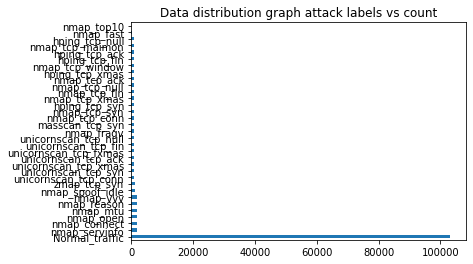

<Figure size 7200x14400 with 0 Axes>

<Figure size 7200x14400 with 0 Axes>

In [9]:
#Data distribustion graph
ds.label.value_counts().plot.barh()
plt.title('Data distribution graph attack labels vs count')
plt.show()
plt.figure(figsize=(100,200))

In [21]:
print (ds.label.value_counts())

nmap_servinfo            2016
nmap_connect             2008
nmap_mtu                 2006
nmap_reason              2006
nmap_open                2006
nmap_vvv                 2002
nmap_spoof_idle          1417
zmap_tcp_syn             1250
unicornscan_tcp_conn     1026
unicornscan_tcp_syn      1017
unicornscan_tcp_xmas     1014
unicornscan_tcp_ack      1014
unicornscan_tcp_fxmas    1014
unicornscan_tcp_fin      1014
unicornscan_tcp_null     1014
nmap_fragv               1003
masscan_tcp_syn          1003
nmap_tcp_conn            1002
nmap_tcp_fin             1001
nmap_tcp_xmas            1001
hping_tcp_syn            1001
nmap_tcp_syn             1001
nmap_tcp_null            1001
hping_tcp_null           1000
nmap_tcp_ack             1000
hping_tcp_xmas           1000
hping_tcp_fin            1000
nmap_tcp_window          1000
nmap_tcp_maimon          1000
hping_tcp_ack            1000
nmap_fast                 206
nmap_top10                 26
Name: label, dtype: int64


In [22]:
#Models only work with numerical values.Process of converting categorical data into numerical data is called Encoding.
# Encoding features
import struct
from sklearn.preprocessing import LabelEncoder
uniqueval = {}
count=0
for feature in ds["ip.src"] :
#print (feature)
  if feature not in uniqueval :
      uniqueval[feature]=count
      count+=1
print (uniqueval)
#data.isna()
#data.isnull()
# converting Hex and other strings to float ,int values
ds["ip.src"].replace({count:uniqueval[count] for count in uniqueval},inplace=True)
ds["eth.type"].replace({j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["eth.type"] if type(j) != float} , inplace=True)
ds["ip.id"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["ip.id"] if type(j) != float} , inplace=True )
ds["ip.checksum"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["ip.checksum"] if type(j) != float} , inplace=True )
ds["ip.flags"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["ip.flags"] if type(j) != float} , inplace=True)
ds["tcp.flags"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["tcp.flags"] if type(j) != float} , inplace=True )
ds["tcp.checksum"].replace({ j : struct.unpack('!f', bytes.fromhex(j[2:]))[0] for j in ds["tcp.checksum"] if type(j) != float} , inplace=True )


{'172.16.0.16': 0, '92.192.62.116': 1, '203.180.205.36': 2, '13.35.206.114': 3, '88.162.108.220': 4, '163.221.219.221': 5, '172.16.0.108': 6, '54.136.224.105': 7, nan: 8, '172.16.0.109': 9, '120.253.44.121': 10, '172.16.0.22': 11, '172.16.0.110': 12, '172.16.0.9': 13, '89.8.230.1': 14, '23.4.190.158': 15, '172.16.0.105': 16, '172.16.0.11': 17, '172.16.0.20': 18, '202.11.241.113': 19, '111.208.11.86': 20, '35.110.181.164': 21, '17.242.68.198': 22, '172.16.0.13': 23, '172.16.0.3': 24, '163.221.156.200': 25, '172.16.0.19': 26, '172.16.0.6': 27, '163.221.171.52': 28, '179.213.118.43': 29, '223.242.93.8': 30, '172.16.0.7': 31, '220.124.105.24': 32, '172.16.0.102': 33, '133.5.44.151': 34, '172.16.0.106': 35, '163.221.159.127': 36, '172.16.0.104': 37, '133.5.216.203': 38, '89.8.238.162': 39, '163.221.17.141': 40, '84.160.190.204': 41, '133.139.205.65': 42, '185.79.219.145': 43, '83.158.21.44': 44, '99.80.177.231': 45, '80.99.191.154': 46, '117.58.23.11': 47, '202.11.244.165': 48, '80.99.191.1

In [31]:
# Replacing NaN values to 0's and printing the resultant ds set for reference
import math
from sklearn.preprocessing import LabelEncoder
ds["tcp.options.mss_val"] = ds["tcp.options.mss_val"].replace(np.nan,0) 
ds["ip.id"] = ds["ip.id"].replace(np.nan,0) 
ds["ip.flags"] = ds["ip.flags"].replace(np.nan,0) 
ds["ip.flags.df"] = ds["ip.flags.df"].replace(np.nan,0)
ds["ip.frag_offset"] = ds["ip.frag_offset"].replace(np.nan,0)
ds["ip.ttl"] = ds["ip.ttl"].replace(np.nan,0) 
ds["ip.len"] = ds["ip.len"].replace(np.nan,0)
ds["tcp.srcport"] = ds["tcp.srcport"].replace(np.nan,0) 
ds["tcp.dstport"] = ds["tcp.dstport"].replace(np.nan,0) 
ds["tcp.seq"] = ds["tcp.seq"].replace(np.nan,0) 
ds["tcp.ack"] = ds["tcp.ack"].replace(np.nan,0) 
ds["tcp.hdr_len"] = ds["tcp.hdr_len"].replace(np.nan,0) 
ds["tcp.flags"] = ds["tcp.flags"].replace(np.nan,0) 
ds["tcp.flags.fin"] = ds["tcp.flags.fin"].replace(np.nan,0) 
ds["tcp.flags.syn"] = ds["tcp.flags.syn"].replace(np.nan,0)
ds["tcp.flags.reset"] = ds["tcp.flags.reset"].replace(np.nan,0) 
ds["tcp.flags.push"] = ds["tcp.flags.push"].replace(np.nan,0) 
ds["tcp.flags.ack"] = ds["tcp.flags.ack"].replace(np.nan,0) 
ds["tcp.flags.urg"] = ds["tcp.flags.urg"].replace(np.nan,0) 
ds["tcp.flags.cwr"] = ds["tcp.flags.cwr"].replace(np.nan,0) 
ds["tcp.window_size"] = ds["tcp.window_size"].replace(np.nan,0) 
ds["tcp.checksum"] = ds["tcp.checksum"].replace(np.nan,0) 
ds["ip.checksum"] = ds["ip.checksum"].replace(np.nan,0) 
ds["ip.id"] = ds["ip.id"].replace(np.nan,0) 
X= ds.iloc[:, 0:30].values 
Y= ds.iloc[:, 30:].values 
#detecting and counting missing values 
Check_missingval = ds.isnull().sum() 
Count_missingval = ds.isna().sum() 
print(Count_missingval) 
print(Y) 
labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)
print(Y)


ip.src                   0
frame_info.encap_type    0
frame_info.time_epoch    0
frame_info.number        0
frame_info.len           0
frame_info.cap_len       0
eth.type                 0
ip.id                    0
ip.flags                 0
ip.flags.df              0
ip.frag_offset           0
ip.ttl                   0
ip.checksum              0
ip.len                   0
tcp.srcport              0
tcp.dstport              0
tcp.seq                  0
tcp.ack                  0
tcp.hdr_len              0
tcp.flags                0
tcp.flags.fin            0
tcp.flags.syn            0
tcp.flags.reset          0
tcp.flags.push           0
tcp.flags.ack            0
tcp.flags.urg            0
tcp.flags.cwr            0
tcp.window_size          0
tcp.checksum             0
tcp.options.mss_val      0
label                    0
dtype: int64
[['unicornscan_tcp_fin']
 ['Normal_traffic']
 ['Normal_traffic']
 ...
 ['Normal_traffic']
 ['Normal_traffic']
 ['Normal_traffic']]
[27  0  0 ...  0  0

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
#using standard scalar (scaling data)
#separating labels and features 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC


#splitting the data for training and evaluation
test_size = 0.2
train_ds, test_ds, train_Y, test_Y = train_test_split(X, Y, test_size=val_size, stratify=ds['label'], random_state=2)
print(f'Train shape: {train_ds.shape}, Validation shape: {val_ds.shape}')


stand_scale = StandardScaler()
X_train = stand_scale.fit_transform(train_ds)
X_test = stand_scale.transform(test_ds)

Train shape: (112130, 30), Validation shape: (28033, 30)


In [48]:
print(X_train, set(test_Y))

[[-0.35765292  0.          0.59963619 ... -0.15237672 -1.08287659
  -0.49934684]
 [-0.35691036  0.         -1.66766947 ... -0.13906136 -1.05359478
   1.95645519]
 [-0.36136571  0.          0.5996361  ... -0.15237672  1.64736524
  -0.49934684]
 ...
 [-0.35468269  0.          0.59963612 ... -0.03830105 -0.23740352
  -0.49934684]
 [-0.34131666  0.         -1.66766947 ... -0.13906136 -1.30999294
   1.95645519]
 [-0.34874223  0.         -1.66768666 ... -0.13906136 -1.3895019
  -0.49934684]] {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}


In [83]:
#Isolation forest 
#It is an unsupervised algorithm that identifies anomalies by isolating outliers using trees.
from sklearn.ensemble import IsolationForest
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.metrics import roc_curve
from datetime import datetime as dt
start=dt.now()
iso = IsolationForest( max_samples=100, random_state=3, contamination='auto')
# hyperparameter tuning
iso.fit(X_train)
# prediction of anomalies
pred=iso.predict(X_test)
#changing the anomaliies values to make them consistent with true values
pred=[1 if i==-1 else 0 for i in pred]
#checking the isolation model performance 
print(classification_report(test_Y, pred))
result1=accuracy_score(test_Y, pred)
print("The accuracy of this model is:",result1)
#Printing the execution time 
running_secs = (dt.now() - start).seconds
print("Execution time of Isolation forest model is ",running_secs,"seconds")


              precision    recall  f1-score   support

           0       0.83      0.81      0.82     20619
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       200
           4       0.00      0.00      0.00       200
           5       0.00      0.00      0.00       200
           6       0.00      0.00      0.00       201
           7       0.00      0.00      0.00       402
           8       0.00      0.00      0.00        41
           9       0.00      0.00      0.00       201
          10       0.00      0.00      0.00       401
          11       0.00      0.00      0.00       401
          12       0.00      0.00      0.00       401
          13       0.00      0.00      0.00       403
          14       0.00      0.00      0.00       284
          15       0.00      0.00      0.00       200
          16       0.00      0.00      0.00       200
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
#SVM model for anomaly detection

#Initializing Support Vector Machine and fitting the training data

from sklearn.svm import SVC
from datetime import datetime as dt
start=dt.now()
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(X_train,train_Y)

#Predicting the classes for test set

pred2 = classifier.predict(X_test)
#printing classification report
print(classification_report(test_Y, pred2))
result2=accuracy_score(test_Y, pred2)
print("The accuracy of this model is:",result2)
#printing executionn time of svm model
running_secs = (dt.now() - start).seconds
print("Execution time of SVM model is ",running_secs,"seconds")



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20619
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       200
           5       1.00      1.00      1.00       200
           6       1.00      1.00      1.00       201
           7       1.00      1.00      1.00       402
           8       0.00      0.00      0.00        41
           9       0.93      1.00      0.96       201
          10       0.75      1.00      0.85       401
          11       0.93      0.90      0.91       401
          12       0.96      0.90      0.93       401
          13       0.94      0.88      0.91       403
          14       0.99      0.84      0.91       284
          15       1.00      1.00      1.00       200
          16       1.00      0.99      1.00       200
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
#Random forest classification algorithm
from datetime import datetime as dt
start=dt.now()
from sklearn.ensemble import RandomForestClassifier
  # Fitting Random Forest Classification to the Training set
ran = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
 # hyper parameter tunning
ran.fit(X_train, train_Y)
# Predicting the Test set results
pred3 = ran.predict(X_test)
#printing classification report
print(classification_report(test_Y, pred3))
result3=accuracy_score(test_Y, pred3)
print("The accuuracy of this model is:",result3)
#Printing execution time of random forest model
running_secs = (dt.now() - start).seconds
print("Execution time of this model is ",running_secs,"seconds")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20619
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       200
           5       1.00      1.00      1.00       200
           6       1.00      1.00      1.00       201
           7       1.00      1.00      1.00       402
           8       0.98      0.98      0.98        41
           9       1.00      1.00      1.00       201
          10       1.00      1.00      1.00       401
          11       1.00      1.00      1.00       401
          12       1.00      1.00      1.00       401
          13       1.00      0.99      1.00       403
          14       0.99      1.00      0.99       284
          15       1.00      1.00      1.00       200
          16       1.00      0.99      1.00       200
          17       1.00    

In [88]:
acc_test=[result1,result2,result3]
res_acc=[element * 100 for element in acc_test]
len(res_acc)

3

In [20]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
output = pd.DataFrame({"Model":['IsolationForest','SVM','Random Forest Classifier'],
                      "Accuracy":res_acc})


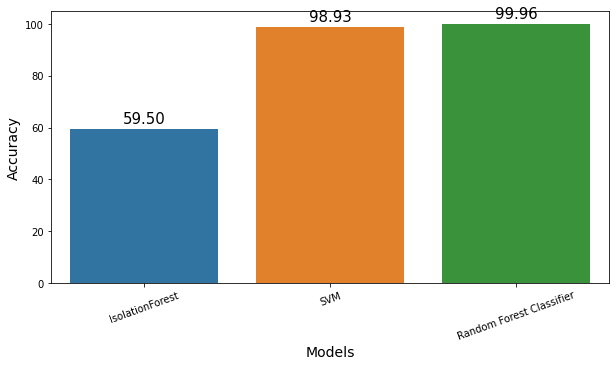

In [90]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 10),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


No handles with labels found to put in legend.


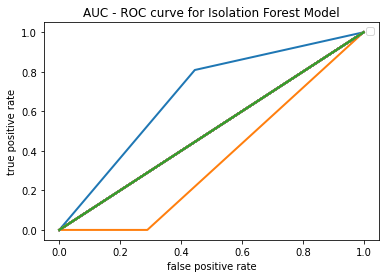

In [120]:
#AUC and ROC curve for IsolationForest Model
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

#computing ROC for each class
fpr=dict()
tpr=dict()
roc_auc=dict()
data = [[0.0 for x in range(33)] for y in range(len(pred))]
for i in range(len(pred)):
  data[i][pred[i]] = 1.0
data1 = [[0.0 for x in range(33)] for y in range(len(test_Y))]
for i1 in range(len(test_Y)):
  data1[i1][test_Y[i1]] = 1.0
a = np.asarray(data1)
b = np.asarray(data)
print(a)
for i in range(33):
        fpr[i], tpr[i], _ = roc_curve(a[:, i], b[:, i])
        plt.plot(fpr[i], tpr[i], lw=2)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("AUC - ROC curve for Isolation Forest Model")
plt.show()



   

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


No handles with labels found to put in legend.


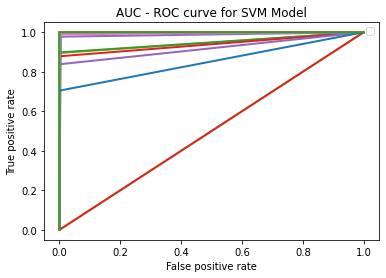

In [111]:
##AUC and ROC curve for SVM Model
#computing ROC for each class
fpr=dict()
tpr=dict()
roc_auc=dict()
d = [[0.0 for x in range(33)] for y in range(len(pred2))]
for i in range(len(pred2)):
  d[i][pred2[i]] = 1.0
data2 = [[0.0 for x in range(33)] for y in range(len(test_Y))]
for i2 in range(len(test_Y)):
  data2[i2][test_Y[i2]] = 1.0
a = np.asarray(data2)
b = np.asarray(d)
print(a)
for i in range(33):
        fpr[i], tpr[i], _ = roc_curve(a[:, i], b[:, i])
        plt.plot(fpr[i], tpr[i], lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="best")
plt.title("AUC - ROC curve for SVM Model")
plt.show()

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


No handles with labels found to put in legend.


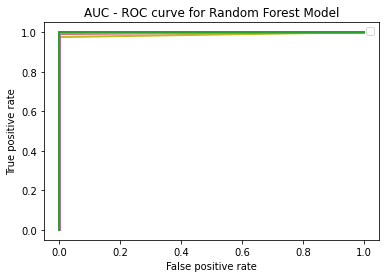

In [110]:
##AUC and ROC curve for RandomForest Model
#computing ROC for each class
fpr2=dict()
tpr2=dict()
roc_auc2=dict()
d = [[0.0 for x1 in range(33)] for y1 in range(len(pred3))]
for i3 in range(len(pred3)):
  d[i3][pred3[i3]] = 1.0
data2 = [[0.0 for x2 in range(33)] for y2 in range(len(test_Y))]
for i2 in range(len(test_Y)):
  data2[i2][test_Y[i2]] = 1.0
a = np.asarray(data2)
b = np.asarray(d)
print(a)
for i4 in range(33):
        fpr2[i4], tpr2[i4], _ = roc_curve(a[:, i4], b[:, i4])
        plt.plot(fpr2[i4], tpr2[i4], lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="best")
plt.title("AUC - ROC curve for Random Forest Model")
plt.show()